# EXA Series, Prototype 014-A

## Introduction

EXA series correspond to only unsupervised learning and technical analysis, which means there will be no fundamental analysis, portfolio optimization and performance evolution or financial feature engineering for alpha factor research. 
Prototype 014 is a use case of Advantage Actor Critic (A2C)

In [4]:
import tensorflow as tf
import gym
import gym_anytrading

from stable_baselines3.common.vec_env import DummyVecEnv
from stable_baselines3 import A2C

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('dark_background')

import warnings
warnings.filterwarnings("ignore")

## FSTE DATA import

In [6]:
data = pd.read_csv('/kaggle/input/ftsedata/ftse.csv', index_col='Date', parse_dates=True)
df = data.copy()
df.sort_values('Date', ascending=True, inplace=True)
df

,Open,High,Low,Close
Date,,,,
2022-02-03,"7,583.00","7,605.75","7,528.69","7,528.84"
2022-02-04,"7,528.84","7,599.73","7,497.21","7,516.40"
2022-02-07,"7,516.40","7,591.65","7,508.48","7,573.47"
2022-02-08,"7,573.47","7,631.31","7,548.19","7,567.07"
2022-02-09,"7,567.07","7,657.93","7,567.07","7,643.42"
...,...,...,...,...
2023-01-30,"7,765.15","7,790.69","7,718.33","7,784.87"
2023-01-31,"7,784.87","7,784.87","7,708.34","7,771.70"
2023-02-01,"7,771.70","7,798.51","7,745.43","7,761.11"


In [7]:
print(df.info())
df.describe()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 254 entries, 2022-02-03 to 2023-02-03
Data columns (total 4 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   Open    254 non-null    object
 1   High    254 non-null    object
 2   Low     254 non-null    object
 3   Close   254 non-null    object
dtypes: object(4)
memory usage: 9.9+ KB
None


,Open,High,Low,Close
count,254,254,254,254
unique,251,252,250,251
top,"7,473.01","7,473.01","7,473.01","7,473.01"
freq,3,2,3,3


In [8]:
#In previous cell, the principal dtype is 'object', so it must be transformed into float values
df = df.applymap(lambda x: float(x.replace(',','')))
df

,Open,High,Low,Close
Date,,,,
2022-02-03,7583.00,7605.75,7528.69,7528.84
2022-02-04,7528.84,7599.73,7497.21,7516.40
2022-02-07,7516.40,7591.65,7508.48,7573.47
2022-02-08,7573.47,7631.31,7548.19,7567.07
2022-02-09,7567.07,7657.93,7567.07,7643.42
...,...,...,...,...
2023-01-30,7765.15,7790.69,7718.33,7784.87
2023-01-31,7784.87,7784.87,7708.34,7771.70
2023-02-01,7771.70,7798.51,7745.43,7761.11


## Introducing GYM and build environment
-------
#### Preliminary work

In [10]:
#thanks to gym_anytrading, 'stock-v0' can be introduced
env = gym.make('stocks-v0', df=df, frame_bound=(5, 200), window_size=5)

In [11]:
env.signal_features

array([[ 7.52884e+03,  0.00000e+00],
       [ 7.51640e+03, -1.24400e+01],
       [ 7.57347e+03,  5.70700e+01],
       [ 7.56707e+03, -6.40000e+00],
       [ 7.64342e+03,  7.63500e+01],
       [ 7.67240e+03,  2.89800e+01],
       [ 7.66102e+03, -1.13800e+01],
       [ 7.53159e+03, -1.29430e+02],
       [ 7.60892e+03,  7.73300e+01],
       [ 7.60378e+03, -5.14000e+00],
       [ 7.53737e+03, -6.64100e+01],
       [ 7.51362e+03, -2.37500e+01],
       [ 7.48433e+03, -2.92900e+01],
       [ 7.49421e+03,  9.88000e+00],
       [ 7.49818e+03,  3.97000e+00],
       [ 7.20738e+03, -2.90800e+02],
       [ 7.48946e+03,  2.82080e+02],
       [ 7.45825e+03, -3.12100e+01],
       [ 7.33020e+03, -1.28050e+02],
       [ 7.42956e+03,  9.93600e+01],
       [ 7.23885e+03, -1.90710e+02],
       [ 6.98714e+03, -2.51710e+02],
       [ 6.95948e+03, -2.76600e+01],
       [ 6.96411e+03,  4.63000e+00],
       [ 7.19072e+03,  2.26610e+02],
       [ 7.09909e+03, -9.16300e+01],
       [ 7.15564e+03,  5.65500e+01],
 

________________________________________________________________________________________________
Info: {'total_reward': -631.7900000000018, 'total_profit': 0.48017973852412377, 'position': 1}
________________________________________________________________________________________________


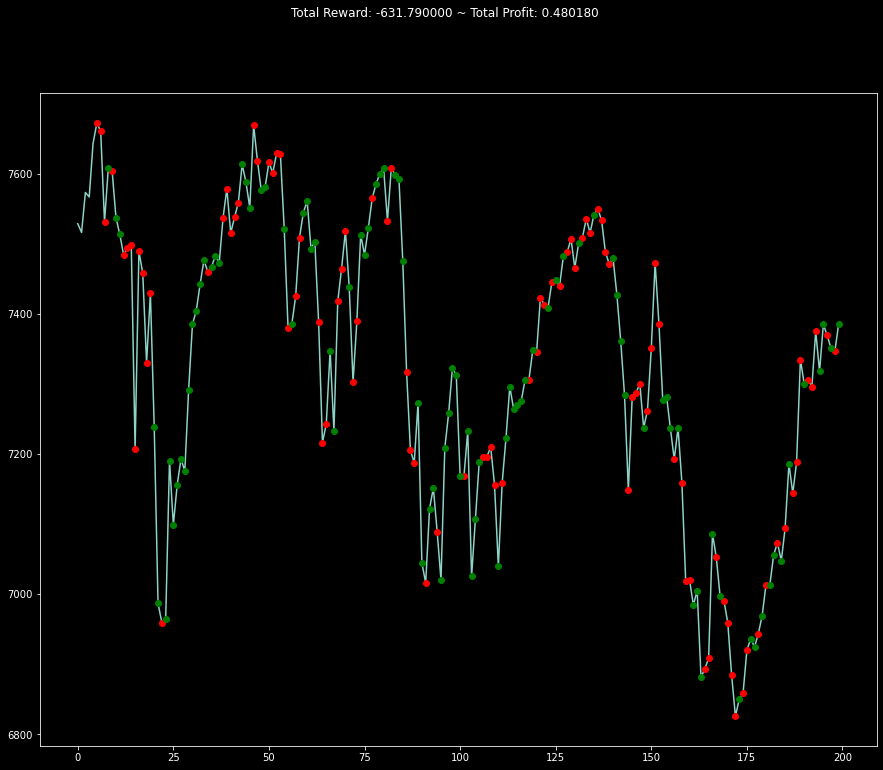

In [12]:
state = env.reset()
while True:
    action = env.action_space.sample()
    n_state, reward, done, info = env.step(action)
    if done:
        print('________________________________________________________________________________________________')
        print(f'Info: {info}')
        print('________________________________________________________________________________________________')
        break

plt.figure(figsize=(15, 12))
plt.cla()
env.render_all()

#total profit being a value between 0 and 1, money was lost

---------
#### Build and Train model

In [29]:
env_maker = lambda: gym.make('stocks-v0', df=df, frame_bound=(5, 100), window_size=5)
env = DummyVecEnv([env_maker])

In [30]:
#from stable_baselines.common.policies import MlpLstmPolicy
#To our day, the latest version stable_baselines3 does not provide all Policies used for models of original stable_baselines (zBs. MlpLstmPolicy)
#Hence, other, avaliable policies are tried on A2C model

model_a2c = A2C('MlpPolicy', env, verbose=1)
model_a2c.learn(total_timesteps=100000)

Using cpu device
-------------------------------------
| time/                 |           |
|    fps                | 816       |
|    iterations         | 100       |
|    time_elapsed       | 0         |
|    total_timesteps    | 500       |
| train/                |           |
|    entropy_loss       | -0.0593   |
|    explained_variance | -1.19e-07 |
|    learning_rate      | 0.0007    |
|    n_updates          | 99        |
|    policy_loss        | 8.14e-05  |
|    value_loss         | 6.94e-05  |
-------------------------------------
------------------------------------
| time/                 |          |
|    fps                | 813      |
|    iterations         | 200      |
|    time_elapsed       | 1        |
|    total_timesteps    | 1000     |
| train/                |          |
|    entropy_loss       | -0.0248  |
|    explained_variance | 0        |
|    learning_rate      | 0.0007   |
|    n_updates          | 199      |
|    policy_loss        | 7.76e-07 |
|    va

## Model Evaluation

In [43]:
env = gym.make('stocks-v0', df=df, frame_bound=(175, 250), window_size=5)
observ = env.reset()
while True:
    observ = observ[np.newaxis, ...]
    action, _states = model_a2c.predict(observ)
    observ, rewards, done, info = env.step(action)
    if done:
        print('________________________________________________________________________________________________')
        print(f'Info: {info}')
        print('________________________________________________________________________________________________')
        break

________________________________________________________________________________________________
Info: {'total_reward': 0.0, 'total_profit': 1.105488485008808, 'position': 1}
________________________________________________________________________________________________


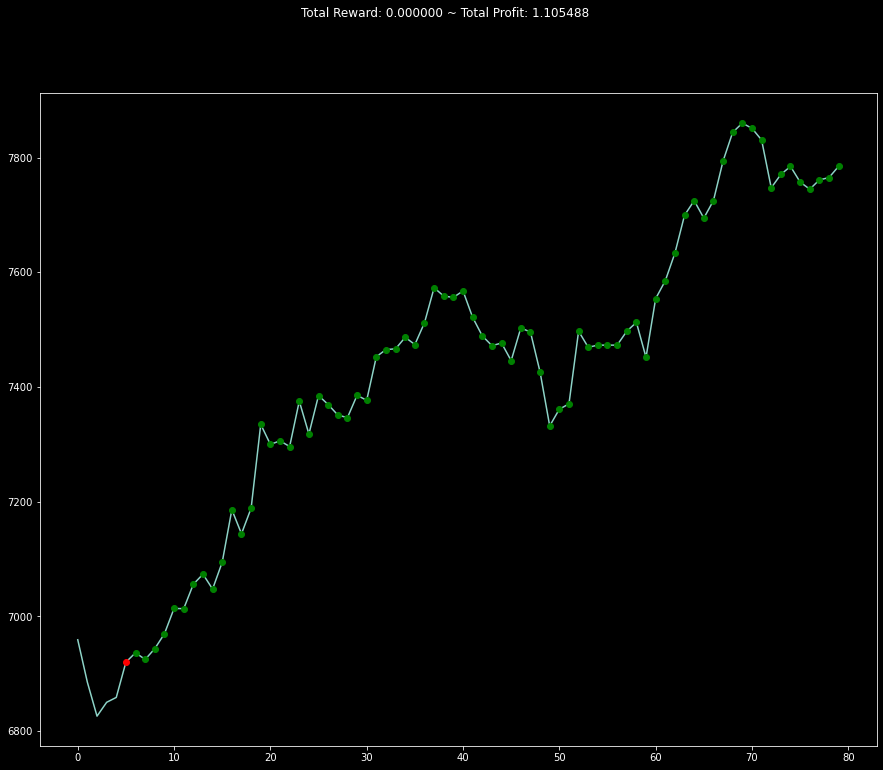

In [44]:
plt.figure(figsize=(15, 12))
plt.cla()
env.render_all()

## Quick Comparative: Turtle technique

In [110]:
dfma['Buy'] = np.zeros(len(dfma['Close']))
dfma['Sell'] = np.zeros(len(dfma['Close']))
dfma['Sold_At'] = np.zeros(len(dfma['Close']))
dfma['Bought_At'] = np.zeros(len(dfma['Close']))

dfma['min7'] = df.loc[:, 'Close'].shift(1).rolling(window=7, center=True).min()
dfma['max7'] = df.loc[:, 'Close'].shift(1).rolling(window=7, center=True).max()
dfma.loc[dfma['min7'] >= dfma['Close'], 'Sell'] = -1
dfma.loc[dfma['max7'] <= dfma['Close'], 'Buy'] = 1
dfma['Bought_At'] = np.where(dfma['Buy'] < 0, dfma['Close'], dfma['Bought_At'])
dfma['Sold_At'] = np.where(dfma['Sell'] < 0, dfma['Close'], dfma['Sold_At'])

dfma

,Open,High,Low,Close,Buy,Sell,min7,max7,Sold_At,Bought_At
Date,,,,,,,,,,
2022-02-03,7583.00,7605.75,7528.69,7528.84,0.0,0.0,NaN,NaN,0.0,0.0
2022-02-04,7528.84,7599.73,7497.21,7516.40,0.0,0.0,NaN,NaN,0.0,0.0
2022-02-07,7516.40,7591.65,7508.48,7573.47,0.0,0.0,NaN,NaN,0.0,0.0
2022-02-08,7573.47,7631.31,7548.19,7567.07,0.0,0.0,NaN,NaN,0.0,0.0
2022-02-09,7567.07,7657.93,7567.07,7643.42,0.0,0.0,7516.40,7672.40,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...
2023-01-30,7765.15,7790.69,7718.33,7784.87,1.0,0.0,7744.87,7784.87,0.0,0.0
2023-01-31,7784.87,7784.87,7708.34,7771.70,0.0,0.0,7744.87,7820.16,0.0,0.0
2023-02-01,7771.70,7798.51,7745.43,7761.11,0.0,0.0,NaN,NaN,0.0,0.0


array([<AxesSubplot:xlabel='Date'>, <AxesSubplot:xlabel='Date'>],
      dtype=object)

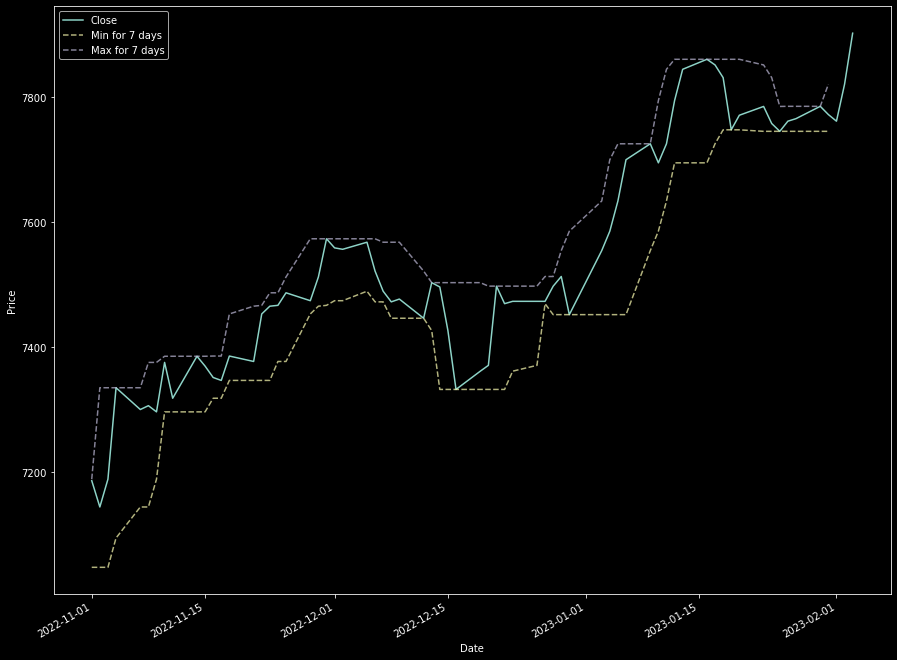

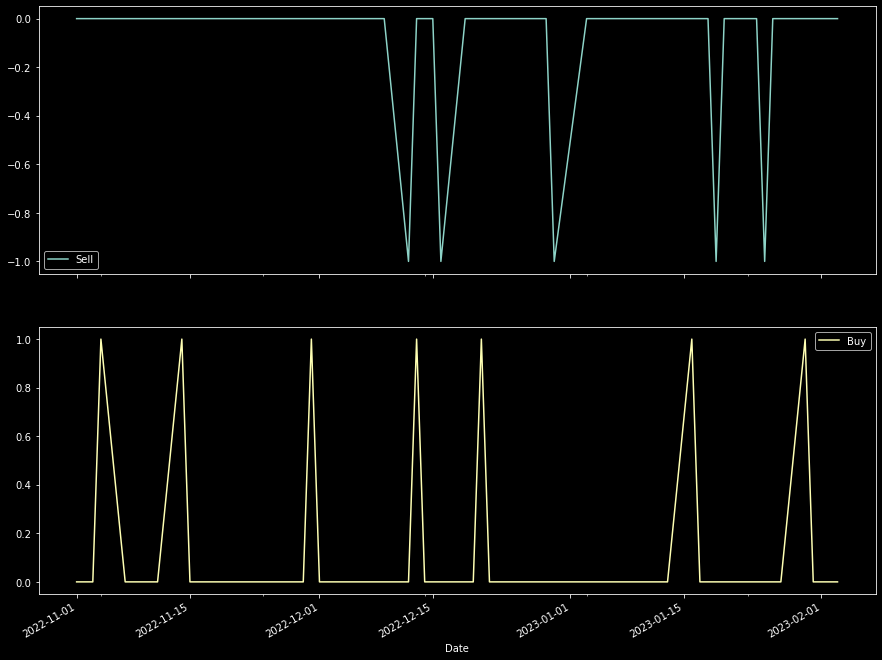

In [111]:
plt.figure(figsize=(15, 12))
dfma.loc['2022-11':, 'Close'].plot(label='Close')
dfma.loc['2022-11':, 'min7'].plot(label='Min for 7 days', alpha=0.7, ls='--')
dfma.loc['2022-11':, 'max7'].plot(label='Max for 7 days', alpha=0.7, ls='--')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
dfma.loc['2022-11':, ['Sell', 'Buy']].plot(subplots=True, figsize=(15, 12))

## Conclusion
-------
Total profit is 1.1055, which means that there is approx 10.55% of gain for days 175 to 250, with the data trained only between dates 5 to 100. However, if EXAP014 was trained on other period of time and tested for another, it could be a totally different number.

At the same time, the comparataive was made with the turtle technique to see the difference between buy and sell signals, their precision and the frequency for the same period range.

The partial conclusion is that even EXAP014 was the least sofisticate of all unsupervised models, it did a better work than the referance tecnhique called 'Turtle'.

----

###### N.B. All models from EXA series has an unique academic goal. Do not take as a financial advice. 